In [1]:
# Purpose: Create regression maps for ENSO and SAM climate modes and save them 
#          as a .nc file
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 28. 09. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/IPOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
from matplotlib.patches import Rectangle # for shaded rectangle
import pandas as pd
import cartopy.crs as ccrs # for maps     
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import cosima_cookbook as cc
import os
import sys
import scipy
import warnings
import cmocean as cm
from wrf import to_np # conversion to arrays required for arrows on maps    
import matplotlib.path as mpath 
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import time
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature

from dask.distributed import Client
client = Client(n_workers=16)         
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16,  0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### 1000 m isobath shelf mask

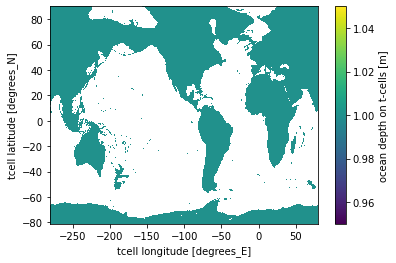

In [2]:
base_spin = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979'
vars = ['ht', 'hu']
for f in range(2): # loop through the t- and u-grid
    field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc')[vars[f]]
    above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
    above1000 = above1000.where(above1000 < 1000, drop=False) # remove all values bigger than 1000
    if f == 0: above1000_tcells = above1000
    if f == 1: above1000_ucells = above1000
above1000_tcells.plot()

### Checking various anomalies

### Using Cosima cookbook to load in the data

In [16]:
%%time
db = 'local_cc_gdata_2sigma.db'; session = cc.database.create_session(db)
# ---------------------------------------------------------------------------------- #
time      = [  12,   24]  # [  30, 1613] = 2012-12-01 to 2017-04-01 just like SOSE   #
sel_lat    = [   0,  500]  # 81.1°S - 59.5°S                                         #
sel_lon    = [   0, 3600]  # [1299, 2200] = 150°W - 60°W                             #
depth      = [  23,   75]  # 100 m to 1000 m                                         #
# ---------------------------------------------------------------------------------- #
exp        = ['01deg_jra55_ryf_IPOCtrl', '01deg_jra55_ryf_IPOPos',
              '01deg_jra55_ryf_IPONeg', '01deg_jra55_ryf_IPOInt',
              '01deg_jra55_ryf_IPO2sNeg']
var = ['vas_10m', 'psl', 'temp', 'salt']
var2 = ['v_10', 'slp', 'temp', 'salt']
chunk_x = ['longitude', 'longitude', 'xt_ocean', 'xt_ocean', 'xu_ocean'] # over which dimensions to chunk
chunk_y = ['latitude', 'latitude', 'yt_ocean', 'yt_ocean', 'yu_ocean']
unit = [' (m s$^{-1}$)', ' (hPa)', ' (°C)', ' (psu)', ' (N m$^{-2}$)']
farbschema = ['RdBu_r', cm.cm.haline]
# plot a quick figure
for e in [1]:
    fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k')
    gs = gridspec.GridSpec(2,4, width_ratios = [1,1,1,1], height_ratios = [1,.2]) 
    
    for v in [0]:#,1,2,3]:
        print(var[v], exp[e][16:])

        if v == 0: 
            ticks = np.linspace(-.1,.1,21) # ticks for meridional wind anomalies on the shelf
        if v == 1: 
            ticks = np.linspace(-60,60,21) # ticks for sea level pressure anomalies on the shelf
        if v == 2: 
            ticks = np.linspace(-.25,.25,21) # ticks for temperature anomalies on the shelf
        if v == 3: 
            ticks = np.linspace(-.05,.05,21) # ticks for salinity anomalies on the shelf
        
        # loading in the data and the climatological data
        if v in [0,1]:
            data = xr.open_mfdataset('/g/data/e14/mv7494/IPOAnt_input/2sigma_negative_phase_fields/' + 'RYF.'+var[v]+'.1990_1991.nc')
            data_clim = xr.open_mfdataset('/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.'+var2[v]+'.1990_1991.nc')
            lengh_of_sim = 10 # ten years
            data_anom = (data - data_clim)
data_anom          

vas_10m IPOPos
CPU times: user 63 ms, sys: 21.3 ms, total: 84.3 ms
Wall time: 100 ms


<xarray.Dataset>
Dimensions:    (latitude: 320, longitude: 640, time: 2920)
Coordinates:
  * latitude   (latitude) float64 -89.57 -89.01 -88.45 ... 88.45 89.01 89.57
  * longitude  (longitude) float64 0.0 0.5625 1.125 1.688 ... 358.3 358.9 359.4
  * time       (time) object 1900-01-01 00:00:00 ... 1900-12-31 21:00:00
Data variables:
    vas_10m    (time, latitude, longitude) float32 dask.array<chunksize=(2920, 320, 640), meta=np.ndarray>

<Figure size 1152x648 with 0 Axes>

In [17]:
data_anom = data_anom.rename({'latitude': 'yt_ocean', 'longitude': 'xt_ocean'}) # rename coordinates so that I can multiply later on
ds2_interp = data_anom.interp(yt_ocean = above1000_tcells.yt_ocean.values, xt_ocean = above1000_tcells.xt_ocean.values)
(ds2_interp*above1000_tcells).mean('yt_ocean')[var[v]].plot()

2024-09-06 07:52:15,055 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 12.48 GiB -- Worker memory limit: 15.70 GiB
2024-09-06 07:52:15,056 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 12.49 GiB -- Worker memory limit: 15.70 GiB
2024-09-06 07:52:15,345 - distributed.worker_memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 12.68 GiB -- Worker memory limit: 15.70 GiB
2024-09-06 07:52:15,345 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memo

KilledWorker: ("('dask_aware_interpnd-transpose-d207fc62918b565d7665145be59f0772', 0, 0, 0)", <WorkerState 'tcp://127.0.0.1:44997', name: 11, status: closed, memory: 0, processing: 1>)

In [ ]:
            data_anom = data_anom.mean('latitude')[var[v]] # select variable and take mean over the latitude direction
            data_anom = xr.concat([data_anom]*lengh_of_sim, dim='time') 
            data_anom = data_anom.assign_coords(time=('time', np.linspace(0,lengh_of_sim,2920*lengh_of_sim)))

            data_anom = data_anom.assign_coords(longitude = (((data_anom.longitude + 180) % 360) - 279.950))
            data_anom = data_anom.roll(longitude=int(len(data_anom['longitude']) / 2),roll_coords=True)

            # next step, multiply with interpolated shelf mask
            


        

vas_10m IPOPos
CPU times: user 155 ms, sys: 14 ms, total: 169 ms
Wall time: 228 ms


<Figure size 1152x648 with 0 Axes>

In [138]:
data_anom

<xarray.DataArray 'vas_10m' (time: 29200, longitude: 640)>
dask.array<rechunk-merge, shape=(29200, 640), dtype=float32, chunksize=(2920, 640), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float64 -279.9 -279.4 -278.8 ... 78.36 78.93 79.49
  * time       (time) float64 0.0 0.0003425 0.000685 ... 9.999 10.0 10.0

vas_10m IPOPos
psl IPOPos
temp IPOPos
salt IPOPos
CPU times: user 2min 15s, sys: 13.5 s, total: 2min 28s
Wall time: 3min 43s


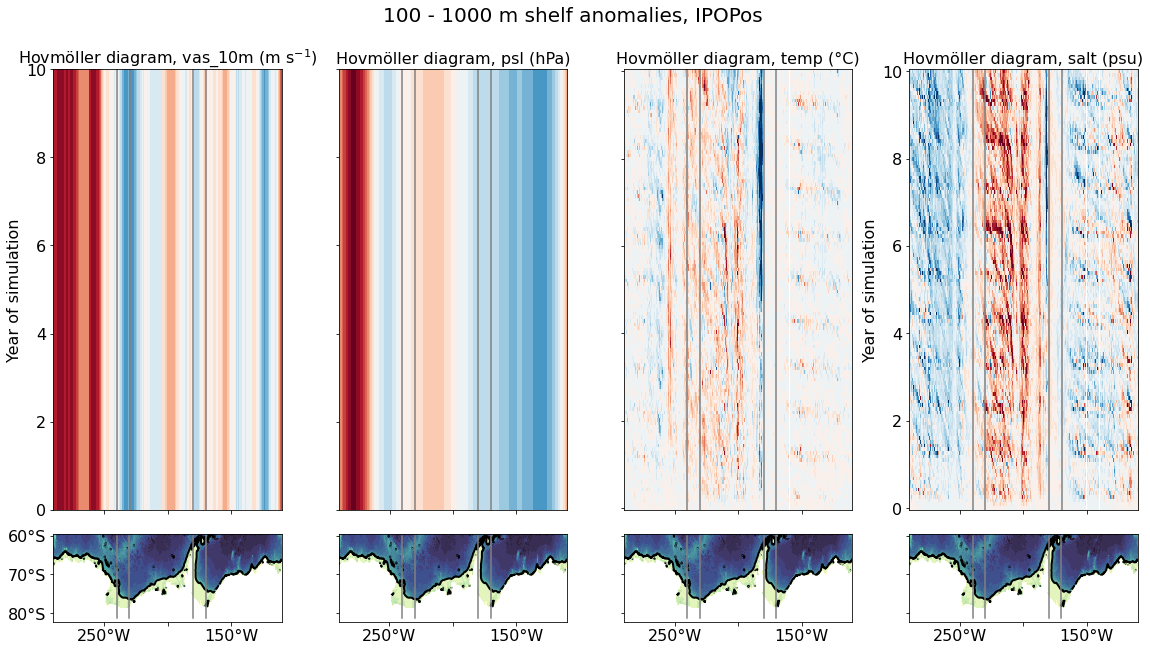

In [ ]:
        if v in [2,3]:
            data = cc.querying.getvar(expt=exp[e], variable=var[v], session=session, frequency='1 monthly', attrs={'cell_methods': 'time: mean'},
                                                chunks = {chunk_y[v]: '200MB', chunk_x[v]: '200MB'}, decode_times=False)[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
            data_clim = cc.querying.getvar(expt='01deg_jra55_ryf_IPOCtrl', variable=var[v], session=session, frequency='1 monthly', attrs={'cell_methods': 'time: mean'},
                                                chunks = {chunk_y[v]: '200MB', chunk_x[v]: '200MB'}, decode_times=False)[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
            data_anom = ((data - data_clim).mean(['st_ocean']) * above1000_tcells).mean(chunk_y[v], skipna=True)
#        else: 
#            data = cc.querying.getvar(expt=exp[e], variable=var[v], session=session, frequency='1 monthly', attrs={'cell_methods': 'time: mean'},
#                                                chunks = {chunk_y[v]: '200MB', chunk_x[v]: '200MB'}, decode_times=False)[:, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
#            data_clim = cc.querying.getvar(expt='01deg_jra55_ryf_IPOCtrl', variable=var[v], session=session, frequency='1 monthly', attrs={'cell_methods': 'time: mean'},
#                                                chunks = {chunk_y[v]: '200MB', chunk_x[v]: '200MB'}, decode_times=False)[:, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
#            data_anom = ((data - data_clim) * above1000_ucells).mean(chunk_y[v], skipna=True).load()

        if v in [2,3]: 
            time_yr = np.linspace(0,10,120) # replace time axis with year index for 1-10 years of simulation
            data_anom = data_anom.assign_coords(time=('time', time_yr))

        # first set of panels -------------------------------------------------------------------- #
        ax1 = plt.subplot(gs[0,v])
    
        data_anom.plot(cmap='RdBu_r', levels=ticks, add_colorbar=False)
        plt.title('Hovmöller diagram, '+ var[v] + unit[v], fontsize=16)
        plt.suptitle('100 - 1000 m shelf anomalies, ' + exp[e][16:], fontsize=20, y=1)
        # ---------------------------------------------------------------------------------------- #
        plt.locator_params(axis='y', nbins=10)
        
        #        ax1.set_yticks([2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154]) # custom x ticks
        
        # lines indicating Ross and Weddell Sea
        plt.axvline(-180, c='grey'); plt.axvline(-160, c='grey') # Ross Sea
        plt.axvline(-60, c='grey'); plt.axvline(-40, c='grey') # Weddell Sea 
        
        ax1.set_xticklabels([]); ax1.set(xlabel=None) # no x axis ticks and labels
        ax1.set_ylabel('Year of simulation', fontsize=16)
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        if v in [1,2]: ax1.set_yticklabels([]); ax1.set(ylabel=None) # no y axis ticks and labels if panel is not on the far left

        # second set of panels ------------------------------------------------------------------- #
        ax1 = plt.subplot(gs[1,v])
        fieldAnt = field[sel_lat[0]:sel_lat[1],:]

        p111 = fieldAnt.plot.contourf(linewidths=2, levels=np.linspace(0,6000,21), cmap=cm.cm.deep, add_colorbar = False) # 1000 m isobath
        p111 = fieldAnt.plot.contour(levels = [1000], linewidths=2, cmap='k') # 1000 m isobath
        
        plt.plot([-180,-180], [-60, -81.09], color = 'grey') # vertical line
        plt.plot([-160,-160], [-60, -81.09], color = 'grey')
        plt.plot([-60,-60], [-60, -81.09], color = 'grey')
        plt.plot([-40,-40], [-60, -81.09], color = 'grey')

        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        ax1.set(xlabel=None); ax1.set(ylabel=None)

        # replace longitude and latitude values -> e.g., from -60°N to 60°S
        labels_x = [item.get_text() for item in ax1.get_xticklabels()]; labels_x = ['', '250°W', '', '150°W', '', '50°W', '0°', '50°W']
        labels_y = [item.get_text() for item in ax1.get_yticklabels()]; labels_y = ['', '80°S', '70°S', '60°S']
        ax1.set_xticklabels(labels_x); ax1.set_yticklabels(labels_y)

        if v in [1,2,3]: ax1.set_yticklabels([]); ax1.set(ylabel=None) # no y axis ticks and labels if panel is not on the far left

    #     plt.yticks([2145,2146,2147,2148,2149,2150,2151,2152,2153,2154])
        plt.savefig(save + 'quick_hovmoeller_shelf_anomalies_'+exp[e],
                    dpi=300, facecolor='w',edgecolor='w', orientation='landscape', papertype=None, format=None,
                    transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)                              #
    # --- end of script ------------------------------------------------------------------------------------------- # 
    # Wall time: 4 min 48 s

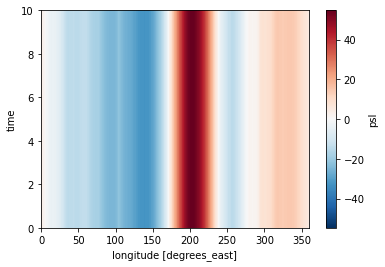

In [97]:
data_anom.plot()

### Taking the difference in temperature and salinity for IPOPos - IPONeg

temp IPO2sNeg
salt IPO2sNeg
CPU times: user 44.1 s, sys: 5.66 s, total: 49.7 s
Wall time: 2min 24s


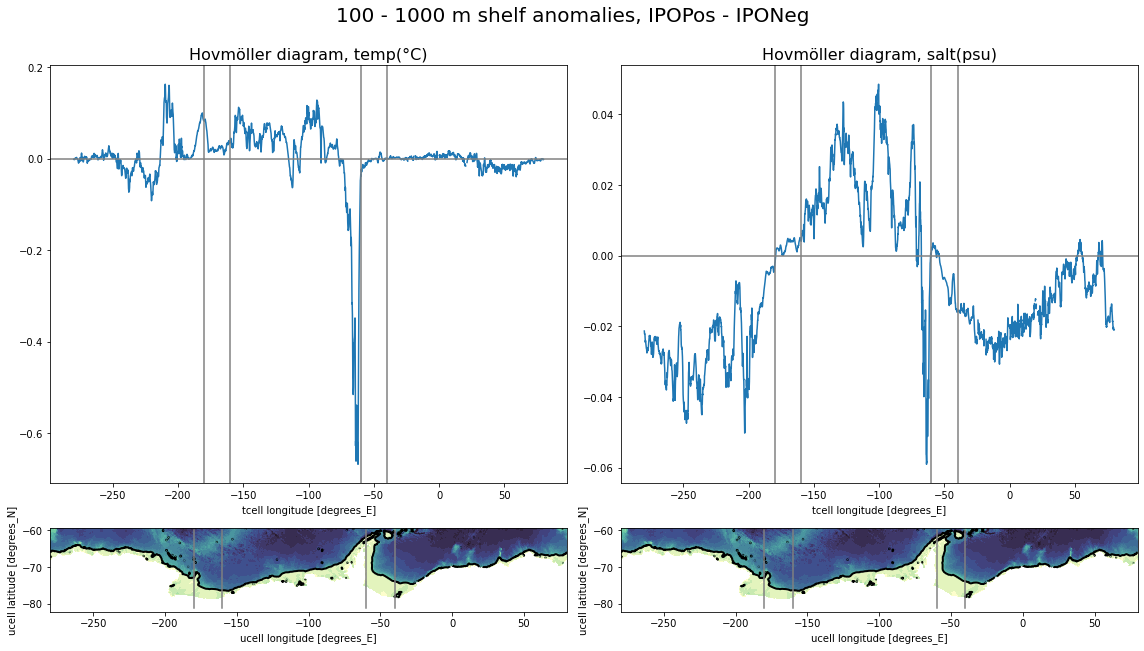

In [60]:
%%time
db = 'local_cc_gdata_2sigma.db'; session = cc.database.create_session(db)
# ---------------------------------------------------------------------------------- #
time      = [  12,   24]  # [  30, 1613] = 2012-12-01 to 2017-04-01 just like SOSE   #
sel_lat    = [   0,  500]  # 81.1°S - 59.5°S                                         #
sel_lon    = [   0, 3600]  # [1299, 2200] = 150°W - 60°W                             #
depth      = [  23,   75]  # 100 m to 1000 m                                         #
# ---------------------------------------------------------------------------------- #
exp        = ['01deg_jra55_ryf_IPOCtrl', '01deg_jra55_ryf_IPOPos',
              '01deg_jra55_ryf_IPONeg', '01deg_jra55_ryf_IPOInt',
              '01deg_jra55_ryf_IPO2sNeg']
var = ['temp', 'salt']
unit = ['(°C)', '(psu)']
farbschema = ['RdBu_r', cm.cm.haline]
# plot a quick figure

fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,2, width_ratios = [1,1], height_ratios = [1,.2]) 
for v in [0,1, 3]:
    print(var[v], exp[e][16:])
    if v == 0: 
        ticks = np.linspace(-.25,.25,21) # ticks for temperature anomalies on the shelf
    if v == 1: 
        ticks = np.linspace(-.05,.05,21) # ticks for salinity anomalies on the shelf
    
    # loading in the data and the climatological data
    data_Pos = cc.querying.getvar(expt=exp[1], variable=var[v], 
                                        session=session, frequency='1 monthly',
                                        attrs={'cell_methods': 'time: mean'},
                                        chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'})[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    data_Neg = cc.querying.getvar(expt=exp[2], variable=var[v], 
                                        session=session, frequency='1 monthly',
                                        attrs={'cell_methods': 'time: mean'},
                                        chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'})[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    data_anom = ((data_Pos - data_Neg).mean(['st_ocean']) * above1000_tcells).mean('yt_ocean', skipna=True).mean('time')
        
    ax1 = plt.subplot(gs[0,v])
    data_anom.plot()
    plt.title('Hovmöller diagram, '+ var[v] + unit[v], fontsize=16)
    plt.suptitle('100 - 1000 m shelf anomalies, IPOPos - IPONeg', fontsize=20, y=1)

    plt.axhline(0, c='grey')
    # lines indicating Ross and Weddell Sea
    plt.axvline(-180, c='grey'); plt.axvline(-160, c='grey') # Ross Sea
    plt.axvline(-60, c='grey'); plt.axvline(-40, c='grey') # Weddell Sea 

    ax1 = plt.subplot(gs[1,v])
    fieldAnt = field[sel_lat[0]:sel_lat[1],:]

    p111 = fieldAnt.plot.contourf(linewidths=2, levels=np.linspace(0,6000,21), cmap=cm.cm.deep, add_colorbar = False) # 1000 m isobath
    p111 = fieldAnt.plot.contour(levels = [1000], linewidths=2, cmap='k') # 1000 m isobath
    
    plt.plot([-180,-180], [-60, -81.09], color = 'grey') # vertical line
    plt.plot([-160,-160], [-60, -81.09], color = 'grey')
    plt.plot([-60,-60], [-60, -81.09], color = 'grey')
    plt.plot([-40,-40], [-60, -81.09], color = 'grey')

    #     plt.yticks([2145,2146,2147,2148,2149,2150,2151,2152,2153,2154])
    plt.savefig(save + 'quick_hovmoeller_shelf_anomalies_'+exp[e],
                dpi=300, facecolor='w',edgecolor='w', orientation='landscape', papertype=None, format=None,
                transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)                              #
# --- end of script ------------------------------------------------------------------------------------------- # 
# Wall time: 4 min 48 s

CPU times: user 13.2 s, sys: 2.03 s, total: 15.2 s
Wall time: 44.1 s


Text(0.5, 1.0, 'IPOPos - IPONeg mean shelf salinities (psu)')

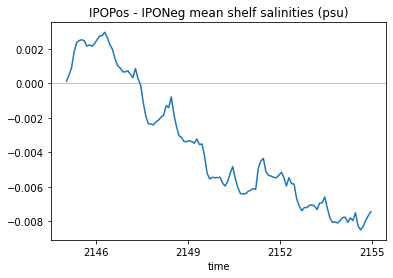

In [68]:
%%time
((data_Pos-data_Neg)*above1000_tcells).mean(['st_ocean', 'yt_ocean', 'xt_ocean']).plot()
plt.axhline(0, color='grey', lw=.5)
plt.title('IPOPos - IPONeg mean shelf salinities (psu)')
# Wall time: 2min

In [5]:
# next step, change tcell latitude to other axis so I can add the contour to the plot

In [43]:
field

<xarray.DataArray 'hu' (yu_ocean: 2700, xu_ocean: 3600)>
dask.array<open_dataset-e2ff7fd54416960a24635239802efe7dhu, shape=(2700, 3600), dtype=float32, chunksize=(2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
    geolon_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point

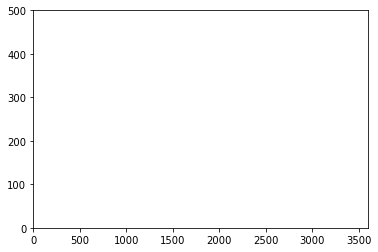

In [15]:
field.plot.contour(levels = [1000], linewidths=2, cmap='k', transform=ccrs.PlateCarree()) # 1000 m isobath

In [21]:
data_anom

<xarray.DataArray (time: 120, xt_ocean: 3600)>
dask.array<mean_agg-aggregate, shape=(120, 3600), dtype=float32, chunksize=(3, 450), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * time      (time) object 2145-01-16 12:00:00 ... 2154-12-16 12:00:00

ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._subplots.AxesSubplot'>

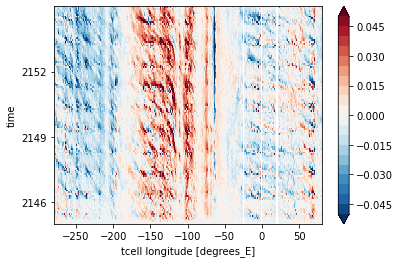

In [20]:
%%time
data_anom.plot(cmap='RdBu_r', levels=ticks)
field.plot.contour(levels = [1000], linewidths=2, cmap='k', transform=ccrs.PlateCarree()) # 1000 m isobath